<a href="https://colab.research.google.com/github/Az140304/v11.24.2024/blob/v11_28_2024/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [ ]:
%pip install tensorflow pandas matplotlib seaborn numpy scipy kaggle

In [1]:
!wget "https://drive.usercontent.google.com/download?id=1s2mJ4-ZrzER1H2gyIL2aKwS3tLyiRxCt&export=download&authuser=0&confirm=t&uuid=5fca0042-0f50-4177-8dd1-9d22a485b17a&at=AENtkXYqhoEXRUfFZqzxByf6P6Jn:1732943358020" -O trash_data.zip

--2024-12-01 07:11:12--  https://drive.usercontent.google.com/download?id=1s2mJ4-ZrzER1H2gyIL2aKwS3tLyiRxCt&export=download&authuser=0&confirm=t&uuid=5fca0042-0f50-4177-8dd1-9d22a485b17a&at=AENtkXYqhoEXRUfFZqzxByf6P6Jn:1732943358020
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197223270 (188M) [application/octet-stream]
Saving to: ‘trash_data.zip’

trash_data.zip      100%[===================>] 188.09M  31.5MB/s    in 6.4s    

2024-12-01 07:11:21 (29.3 MB/s) - ‘trash_data.zip’ saved [197223270/197223270]



In [2]:
!unzip -o -q trash_data -d data

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras

In [4]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
data_dir = 'data'
os.listdir(data_dir)

['disc',
 'watergallon',
 'paper',
 'ceramicsbowl',
 'rag',
 'plasticbag',
 'pen',
 'glassbottle',
 'bottlecap',
 'newspaper',
 'tire',
 'cans',
 'spoonfork',
 'galvanizedsteel',
 'cardboard',
 'plasticbottle']

In [6]:
data_dir = "data/"

In [7]:
print(len(tf.config.list_physical_devices('GPU')))

1


# Exploratory Dataset

In [8]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
data_flow = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 10579 images belonging to 16 classes.


In [9]:
class_labels = list(data_flow.class_indices.keys())
total_label = len(class_labels)

print("Total kategori yang ada : ", total_label)
print("Kategori yang ada:", class_labels)

Total kategori yang ada :  16
Kategori yang ada: ['bottlecap', 'cans', 'cardboard', 'ceramicsbowl', 'disc', 'galvanizedsteel', 'glassbottle', 'newspaper', 'paper', 'pen', 'plasticbag', 'plasticbottle', 'rag', 'spoonfork', 'tire', 'watergallon']


In [10]:
from collections import Counter

class_counts = Counter()
for label in class_labels:
    class_counts[label] = len(os.listdir(os.path.join(data_dir, label)))

print("Distribusi gambar per kategori:", class_counts)

Distribusi gambar per kategori: Counter({'ceramicsbowl': 872, 'glassbottle': 859, 'cardboard': 716, 'plasticbag': 712, 'galvanizedsteel': 706, 'cans': 692, 'paper': 683, 'bottlecap': 680, 'plasticbottle': 679, 'pen': 653, 'disc': 611, 'spoonfork': 583, 'rag': 579, 'newspaper': 575, 'tire': 515, 'watergallon': 464})


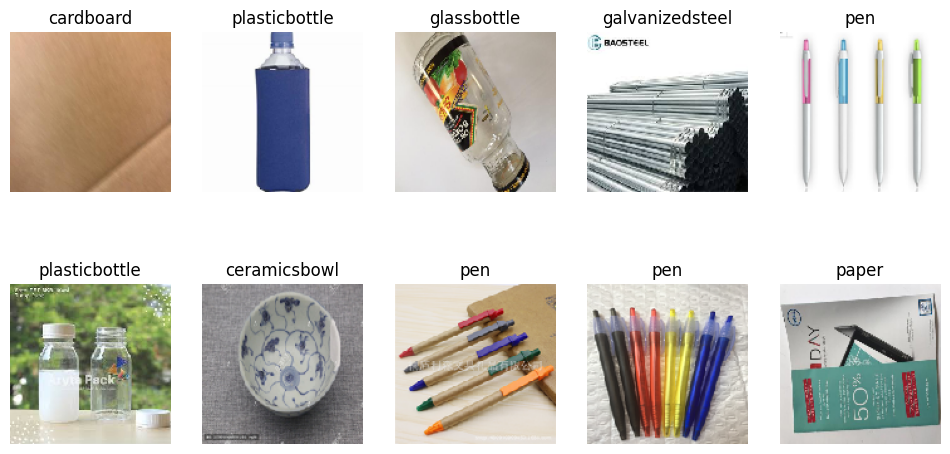

In [ ]:
def plot_images(data_flow, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img, label = next(data_flow)
        plt.subplot(2, 5, i+1)
        plt.imshow(img[0])  # Ambil gambar pertama dari batch
        plt.title(class_labels[np.argmax(label[0])])
        plt.axis("off")
    plt.show()

plot_images(data_flow)

In [11]:
img_shape = data_flow.image_shape
print("Dimensi gambar yang digunakan:", img_shape)

Dimensi gambar yang digunakan: (128, 128, 3)


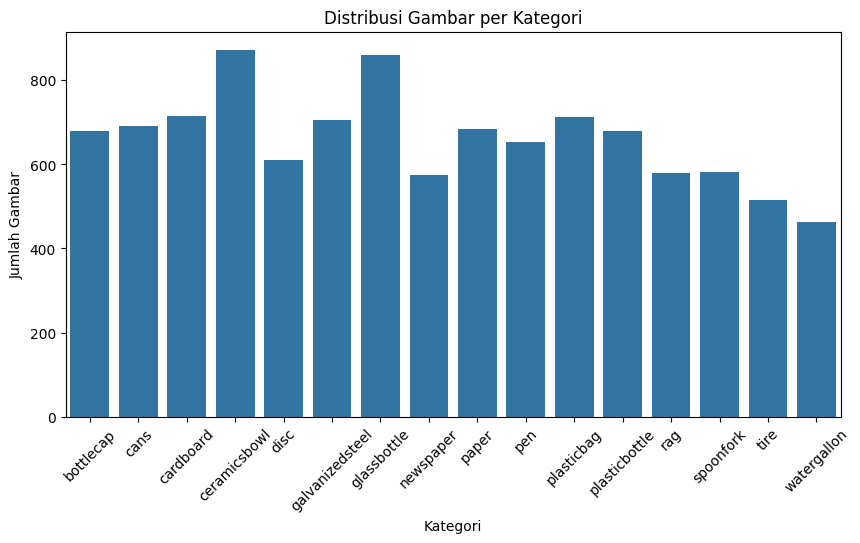

In [12]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Distribusi Gambar per Kategori")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

# Preprocessing Data

## Image Data Generator

In [18]:
target_size = (224, 224)
batch_size = 32

# Generator untuk train dan validation set (30% dari data training untuk validation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.3  # Split 20% untuk validation
)

test_datagen = ImageDataGenerator(rescale=1./255)


## Load Dataset

In [19]:
# Flow untuk training data
train_flow = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Flow untuk validation data
val_flow = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 7415 images belonging to 16 classes.
Found 3164 images belonging to 16 classes.


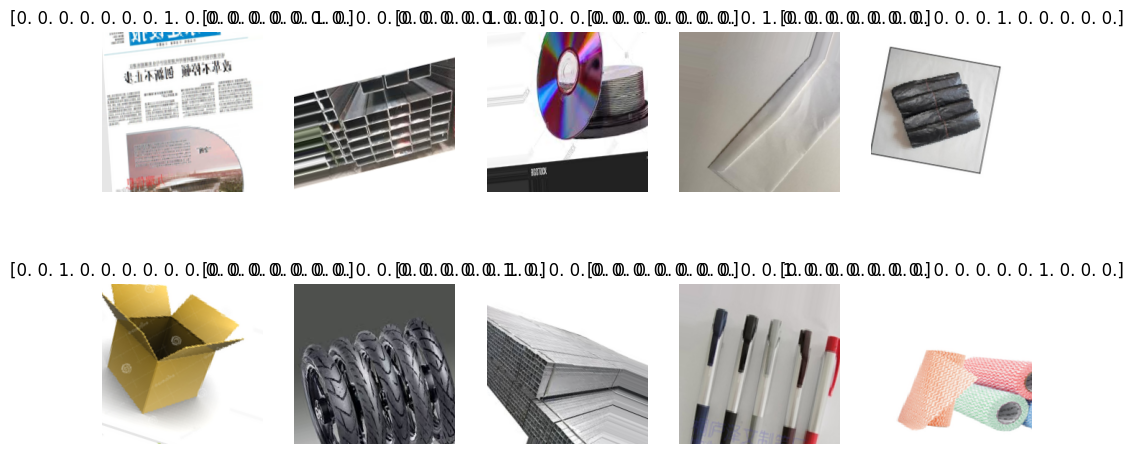

In [ ]:
def plot_augmented_images(data_flow, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img, label = next(data_flow)
        plt.subplot(2, 5, i+1)
        plt.imshow(img[0])  # Menampilkan gambar pertama dari batch
        plt.title(label[0])
        plt.axis("off")
    plt.show()

# Visualisasi beberapa gambar dari train_flow
plot_augmented_images(train_flow)

In [53]:
from tensorflow.keras.layers import Dropout,Dense
model = tf.keras.models.Sequential([
		tf.keras.Input(shape=(224, 224, 3)),
        # Convolution and Pooling layers
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.65),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(total_label, activation='softmax')




   ])


model.compile(
   loss='categorical_crossentropy',
   optimizer=tf.keras.optimizers.Adam(),
   metrics=['accuracy']
)

   ### END CODE HERE #

In [20]:

base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [21]:
base_model.trainable = False

In [22]:
image_batch, label_batch = next(iter(train_flow))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [47]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Tetap gunakan learning rate awal
    else:
        return lr * 0.5  # Kurangi learning rate menjadi setengahnya setelah epoch ke-10

# Membuat callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [39]:
from tensorflow.keras.layers import Dropout,Dense

model = tf.keras.Sequential(
    [
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.65),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        tf.keras.layers.Dense(total_label, activation="softmax")
    ]
)

model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
)

In [25]:
model = create_model()

NameError: name 'create_model' is not defined

In [54]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 52, 52, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 478,800 (1.83 MB)

 Trainable params: 478,800 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(
	train_flow,
	epochs=20,
	validation_data=val_flow,
	callbacks=[lr_scheduler]
)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 158s 614ms/step - accuracy: 0.0767 - loss: 2.7690 - val_accuracy: 0.1106 - val_loss: 2.7115 - learning_rate: 0.0010
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 179s 563ms/step - accuracy: 0.1043 - loss: 2.6874 - val_accuracy: 0.2007 - val_loss: 2.5461 - learning_rate: 0.0010
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 127s 538ms/step - accuracy: 0.1409 - loss: 2.5929 - val_accuracy: 0.1953 - val_loss: 2.4874 - learning_rate: 0.0010
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 142s 538ms/step - accuracy: 0.1792 - loss: 2.4913 - val_accuracy: 0.2266 - val_loss: 2.3813 - learning_rate: 0.0010
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 127s 539ms/step - accuracy: 0.2055 - loss: 2.4176 - val_accuracy: 0.2816 - val_loss: 2.3536 - learning_rate: 0.0010
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 142s 539ms/step - accuracy: 0.2420 - loss: 2.3729 - val_accuracy: 0.2585 - val_loss: 2.3434 - learning_rate: 0.0010
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 126s 535ms/step - accura

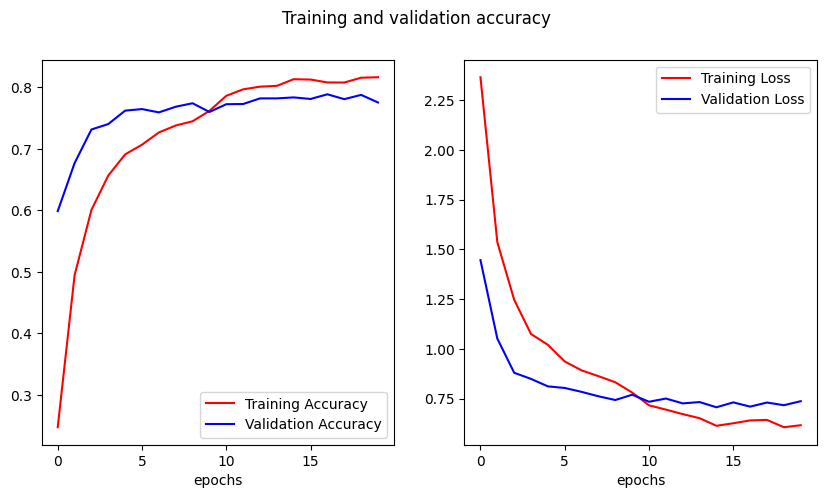

In [42]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [43]:
test_loss, test_accuracy = model.evaluate(test_flow)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

NameError: name 'test_flow' is not defined

In [44]:
model.save("garbage_classification_tf_16_v2.h5")

In [45]:
#tf.saved_model.save(model, "garbage_classification_tf_16_v2")
model.save("garbage_classification_tf_16.keras")